In [1]:
####################################################
#importing libraries
####################################################

import torch 
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 120
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
####################################################
#importing libraries
####################################################

batch_size = 64
input_size = 7
output_size = 6


seq_len = 3
learning_rate = 0.0080409
num_epochs = 100
dropout = 0

seed = 7123515
load_model = True

In [3]:
####################################################
#data importing
####################################################

df = pd.read_excel('ALL VAR cleaned.xlsx')
df.Date = pd.to_datetime(df.Date, format = '%m/%d/%Y')
df = df.set_index('Date')
df.head()

,Avg. Hum (%),Avg. Temp. (Celcius),Max. Temp. (Celcius),Min. Temp. (Celcius),Total Rainfall (mm),Wind Speed (Knots),Total Sunshine Hrs.,SO2 (ppb),NO2 (ppb),CO (ppm),O3 (ppb),PM2.5 (ug/m3),PM10 (ug/m3)
Date,,,,,,,,,,,,,
2013-01-01,69,17.0,24.6,11.0,0,0.0,5.1,11.167710,31.700016,3.013273,6.001289,234.622679,407.192110
2013-01-02,68,18.4,26.7,11.5,0,2.0,5.5,10.918571,37.720404,2.879839,5.035271,253.715176,423.981442
2013-01-03,74,18.9,25.2,14.9,0,0.0,0.0,10.960147,49.219523,3.048507,5.853110,270.920463,412.034426
2013-01-04,70,19.9,25.6,14.8,0,2.0,0.0,14.988741,26.149916,2.203914,10.753946,241.622788,267.661431
2013-01-05,60,18.7,25.0,14.6,0,2.0,2.5,7.386188,34.626808,1.423127,5.642880,137.012858,193.417860


In [4]:
#data scaling
df_scaled = (df - df.mean())/ df.std()
df_scaled.head()

#storing mean and std
df_np_mean = df.mean().to_numpy()
df_np_std = df.std().to_numpy()

#dropping date column
df_scaled.reset_index(inplace = True)
df_scaled = df_scaled.drop('Date', 1)
df_scaled.head()

,Avg. Hum (%),Avg. Temp. (Celcius),Max. Temp. (Celcius),Min. Temp. (Celcius),Total Rainfall (mm),Wind Speed (Knots),Total Sunshine Hrs.,SO2 (ppb),NO2 (ppb),CO (ppm),O3 (ppb),PM2.5 (ug/m3),PM10 (ug/m3)
0,-0.276565,-2.252157,-1.771845,-2.348275,-0.362854,-1.909625,-0.041315,0.387179,0.676108,0.909184,0.056248,2.566658,3.152157
1,-0.367972,-1.912556,-1.203057,-2.245625,-0.362854,-0.197161,0.094066,0.357725,1.005929,0.816029,-0.067994,2.872272,3.335737
2,0.180470,-1.791270,-1.609334,-1.547603,-0.362854,-1.909625,-1.767425,0.362640,1.635896,0.933782,0.037191,3.147677,3.205105
3,-0.185158,-1.548697,-1.500994,-1.568133,-0.362854,-0.197161,-1.767425,0.838921,0.372052,0.344141,0.667500,2.678709,1.626486
4,-1.099229,-1.839784,-1.663505,-1.609193,-0.362854,-0.197161,-0.921292,-0.059892,0.836450,-0.200956,0.010152,1.004217,0.814684


In [5]:
####################################################
#sequencing
####################################################

def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix+1 >= len(sequences): break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:7], sequences[end_ix+1, 7:13]
        X.append(seq_x)
        y.append(seq_y)
    return X, y

array = df_scaled.iloc[:, :].values
print ('shape of the datset array: {}'.format(array.shape))
X, y = split_sequences(array, seq_len)
X_array = np.array(X, dtype = np.float32)
y_array = np.array(y)
print ('sequenced X array shape: {}'.format(X_array.shape))
print ('sequenced y array shape: {}'.format(y_array.shape))

shape of the datset array: (2184, 13)
sequenced X array shape: (2180, 3, 7)
sequenced y array shape: (2180, 6)


In [6]:
####################################################
#output mask preparation
####################################################

df_mask = pd.read_excel('COMBINED CAMS MASK.xlsx')
#print(df_mask.head())

mask_array = df_mask.iloc[:, :].values
#print(mask_array.shape)

#sequencing
def mask_sequence(sequence, n_steps):
    y = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_iy = i + n_steps
        # check if we are beyond the dataset
        if end_iy+1 >= len(sequence): break
        # gather input and output parts of the pattern
        seq_y = sequence[end_iy+1, 0:6]
        y.append(seq_y)
    return y

mask_list = mask_sequence(mask_array, seq_len)
mask_array = np.array(mask_list)
print(mask_array.shape)

(2180, 6)


In [7]:
####################################################
#making dataset and subsets
####################################################

class AirMeteoroDataset(Dataset):
    def __init__(self):
        self.len = X_array.shape[0]
        self.X_data = torch.from_numpy(X_array)
        self.y_data = torch.from_numpy(y_array)
        self.y_mask = torch.from_numpy(mask_array)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.y_mask[index], index

    def __len__(self):
        return self.len
    
dataset = AirMeteoroDataset()


#dataset_random_split
train_size = round(len(X_array) * 0.7)
val_size = round((len(X_array) - train_size)/2)
test_size = len(X_array) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset,[train_size, val_size, test_size], generator = torch.Generator().manual_seed(seed))

In [8]:
#merge train_val

trainval_sets= []
trainval_sets.append(train_set)
trainval_sets.append(val_set)
train_val_set = torch.utils.data.ConcatDataset(trainval_sets)

In [9]:
####################################################
#making mini-batches for training set
####################################################
train_loader = DataLoader(dataset = train_val_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)

test_loader = DataLoader(dataset = test_set,
                          batch_size = batch_size,
                          drop_last = True,
                          shuffle = True)


In [10]:
####################################################
#model building
####################################################

class Model(nn.Module):
    def __init__(self, 
                 input_size, 
                 output_size, 
                 seq_len, 
                 dropout):
        super(Model, self).__init__()
        self.input_size = input_size*seq_len
        self.output_size = output_size
        
        self.dropout = nn.Dropout(p = dropout)
        
        self.linear = nn.Linear(self.input_size, self.output_size)

    def forward(self, X):
        
        out = self.linear(self.dropout(X))
        
        
        return out

In [11]:
####################################################
#custom loss function
####################################################

class modsmoothl1(nn.SmoothL1Loss):
    def __init__(self, size_average=None, reduce=None, reduction = 'none'):
        super(modsmoothl1, self).__init__(size_average, reduce, reduction)
        
    def forward(self, observed, predicted, mask):
        predicted_masked = mask*predicted
        loss = F.smooth_l1_loss(observed, predicted_masked, reduction=self.reduction)
        avg_loss = torch.sum(loss)/torch.sum(mask)
        return avg_loss

In [12]:
####################################################
#model initialization
####################################################

forecast_model = Model(input_size,
                       output_size,
                       seq_len, 
                       dropout).cuda().float()

criterion = modsmoothl1()
optimizer = torch.optim.RMSprop(forecast_model.parameters(), lr = learning_rate)

In [13]:
####################################################
#save and load checkpoints
####################################################

def save_checkpoint(state, filename="MLR Final model.pth.tar"):
    print("Saving checkpoint...")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("Loading checkpoint...")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [14]:
####################################################
#model training
####################################################

if load_model == False:
    all_train_loss = []
    all_val_loss = []
    total_iter = 0

    for epoch in range(num_epochs):
        forecast_model.train()
        epoch_total_loss = 0.0

        for i, (X_data, y_data, y_mask, index) in enumerate(train_loader):
            optimizer.zero_grad()

            X_data = X_data.cuda().float()
            y_data = y_data.cuda().float()
            y_mask = y_mask.cuda().float()        

            y_pred = forecast_model(X_data.view(batch_size, input_size*seq_len))
            loss = criterion(y_data, y_pred, y_mask)

            loss.backward()
            optimizer.step()

            epoch_total_loss = epoch_total_loss + loss.item()

        epoch_avg_loss = epoch_total_loss/len(train_loader)    
        if (epoch +1) % round(num_epochs/10) == 0:
            print (f'Train loss after Epoch [{epoch+1}/{num_epochs}]: {epoch_avg_loss:.6f}')

        all_train_loss.append(epoch_avg_loss)


In [15]:
#saving test and validation losses
if load_model == False:
    print("Saving losses...")
    df_train_loss = pd.DataFrame(all_train_loss, columns = ["Values"])
    df_train_loss.to_csv('train_loss.csv', index = False)

    df_val_loss = pd.DataFrame(all_val_loss, columns = ["Values"])
    df_val_loss.to_csv('Validation_loss.csv', index = False)
    
    checkpoint = {"state_dict": forecast_model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint)

In [19]:
####################################################
#saving test and validation losses
####################################################

if load_model == True:
    import itertools
    print("Loading losses...")
    df_train_loss = pd.read_csv('Train_loss.csv')
    all_train_loss_2d = df_train_loss.values.tolist()
    all_train_loss = list(itertools.chain.from_iterable(all_train_loss_2d))

    df_val_loss = pd.read_csv('Validation_loss.csv')
    all_val_loss_2d = df_val_loss.values.tolist()
    all_val_loss = list(itertools.chain.from_iterable(all_val_loss_2d))
    
    load_checkpoint(torch.load("MLR Final model.pth.tar"), forecast_model, optimizer)

Loading losses...
Loading checkpoint...


Text(0, 0.5, 'Loss')

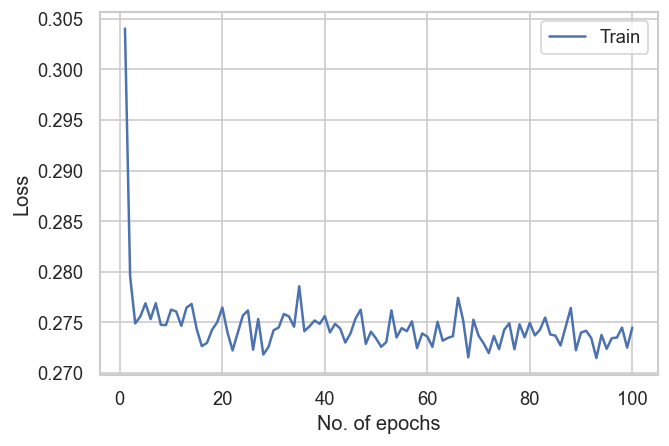

In [20]:
####################################################
#final training plot
####################################################

plt.plot(list(range(1, num_epochs + 1)), all_train_loss, label = 'Train')
plt.legend(loc="upper right")
plt.xlabel('No. of epochs')
plt.ylabel('Loss')

In [21]:
####################################################
#testing on the test set
####################################################

all_index = torch.empty(0).cuda()
all_obs = torch.empty(0, output_size).cuda()
all_pred = torch.empty(0, output_size).cuda()
with torch.no_grad():
    total_test_loss = 0.0
    for i, (X_test, y_test, y_mask_test, index) in enumerate(test_loader):
        X_test = X_test.cuda().float()
        y_test = y_test.cuda().float()
        y_mask_test = y_mask_test.cuda().float()
        index = index.cuda().float()
        
        test_pred = forecast_model(X_test.view(batch_size, input_size*seq_len))
        test_loss = criterion(y_test, test_pred, y_mask_test)
        total_test_loss = total_test_loss + test_loss.item()
        
        all_index = torch.cat((all_index, index),0)
        all_obs = torch.cat((all_obs, y_test), 0)
        all_pred = torch.cat((all_pred, test_pred), 0)
        
        
    avg_test_loss = total_test_loss/len(test_loader)
    print(avg_test_loss)

0.27320497632026675


In [22]:
####################################################
#output preparation 
####################################################

pred_out_np = all_pred.cpu().numpy()
obs_out_np = all_obs.cpu().numpy()
df_out_mean = df_np_mean[7:13]
df_out_std = df_np_std[7:13]
final_pred = pred_out_np * df_out_std + df_out_mean
final_observed = obs_out_np * df_out_std + df_out_mean
all_index = all_index.cpu().numpy()

In [23]:
####################################################
#obs output export
####################################################

out_obs_data = pd.DataFrame({'SO2  ': final_observed[:, 0],
                         'NO2': final_observed[:, 1],
                         'CO': final_observed[:, 2],
                         'O3': final_observed[:, 3],
                         'PM2.5': final_observed[:, 4], 
                         'PM10': final_observed[:, 5],
                         'Index': all_index})
filename_obs = 'MLR plot_obs.xlsx'
out_obs_data.to_excel(filename_obs, index=True)

In [24]:
####################################################
#pred output export
####################################################

out_pred_data = pd.DataFrame({'SO2  ': final_pred[:, 0],
                         'NO2': final_pred[:, 1],
                         'CO': final_pred[:, 2],
                         'O3': final_pred[:, 3],
                         'PM2.5': final_pred[:, 4], 
                         'PM10': final_pred[:, 5],
                         'Index': all_index})
filename_pred = 'MLR plot_pred.xlsx'
out_pred_data.to_excel(filename_pred, index=True)

In [25]:
####################################################
#fixed
####################################################

df_obs = pd.read_excel("MLR plot_obs.xlsx")
df_obs[df_obs < 0.0001] = 0
df_obs.to_excel("MLR plot_obs_final.xlsx")

df_pred = pd.read_excel("MLR plot_pred.xlsx")
df_pred[df_pred < 0.0001] = 0
df_pred.to_excel("MLR plot_pred_final.xlsx")